<a href="https://colab.research.google.com/github/BilalHamdann/Facial-Expression-Recognition/blob/main/FacialRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from __future__ import print_function
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [4]:
import zipfile
import os

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("archive")

array([[[119, 119, 119],
        [122, 122, 122],
        [ 62,  62,  62],
        ...,
        [128, 128, 128],
        [127, 127, 127],
        [119, 119, 119]],

       [[121, 121, 121],
        [114, 114, 114],
        [ 37,  37,  37],
        ...,
        [119, 119, 119],
        [132, 132, 132],
        [117, 117, 117]],

       [[121, 121, 121],
        [ 96,  96,  96],
        [ 22,  22,  22],
        ...,
        [104, 104, 104],
        [138, 138, 138],
        [125, 125, 125]],

       ...,

       [[185, 185, 185],
        [189, 189, 189],
        [189, 189, 189],
        ...,
        [159, 159, 159],
        [165, 165, 165],
        [160, 160, 160]],

       [[183, 183, 183],
        [167, 167, 167],
        [185, 185, 185],
        ...,
        [158, 158, 158],
        [163, 163, 163],
        [158, 158, 158]],

       [[177, 177, 177],
        [170, 170, 170],
        [186, 186, 186],
        ...,
        [157, 157, 157],
        [156, 156, 156],
        [161, 161, 161]]], dtype=uint8)
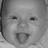

In [5]:
# Set path to the dataset
image_path = '/content/archive/train/happy'

# List all images in the 'happy' folder
images = os.listdir(image_path)

# Load the first image
img_file = os.path.join(image_path, images[0])
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib
display(img)


In [ ]:
img.shape

(48, 48, 3)

In [ ]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
gaussian_blur = cv2.GaussianBlur(img, (3, 3), 0)

median_blur = cv2.medianBlur(img, 5)

average_blur = cv2.blur(img, (5, 5))

laplacian = cv2.Laplacian(img, cv2.CV_64F)
laplacian_img = cv2.convertScaleAbs(laplacian)

canny = cv2.Canny(img, 50, 150)

# Unsharp mask
unsharp_mask = cv2.addWeighted(img, 1.5, gaussian_blur, -0,5, 0)

bilateral_filter = cv2.bilateralFilter(img, 9, 75, 75)

denoised_img = cv2.fastNlMeansDenoising(img, h=15, templateWindowSize=7, searchWindowSize=21)

equalized_hist = cv2.equalizeHist(img)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(img)

denoised_hist = cv2.equalizeHist(denoised_img)
hist_denoised = cv2.fastNlMeansDenoising(equalized_hist, h=15, templateWindowSize=7, searchWindowSize=21)
denoised_clahe = clahe.apply(denoised_img)
hist_clahe_denoised = clahe.apply(equalized_hist)
hist_clahe_denoised = cv2.fastNlMeansDenoising(hist_clahe_denoised, h=15, templateWindowSize=7, searchWindowSize=21)

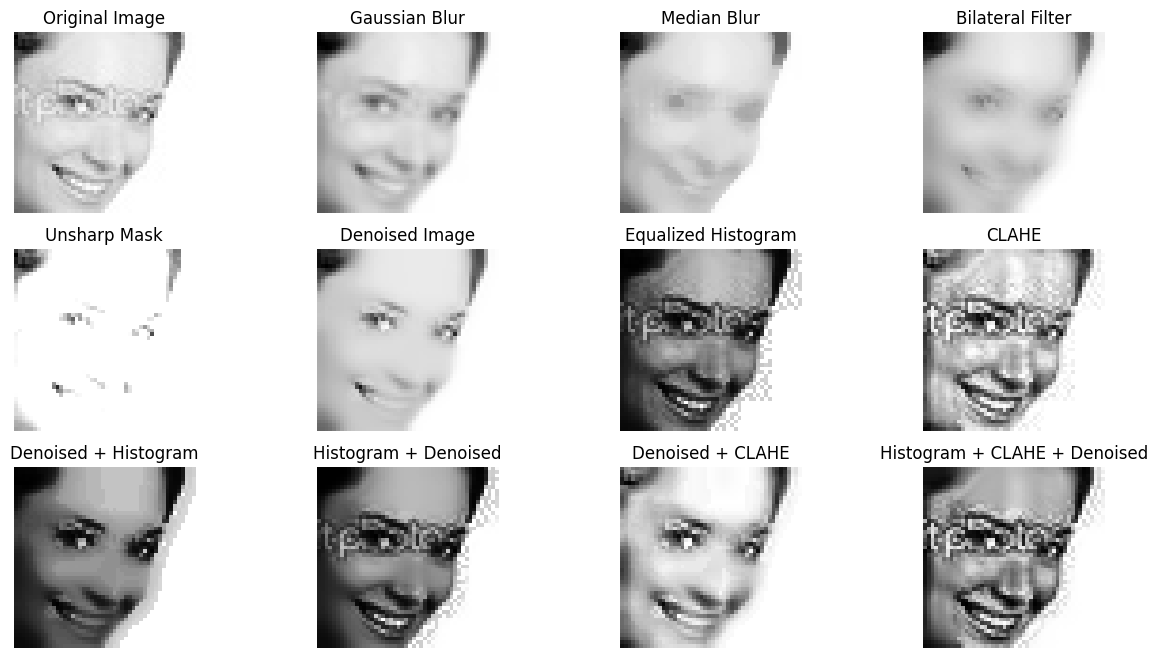

In [ ]:
images = [
    img,
    gaussian_blur,
    median_blur,
    bilateral_filter,
    unsharp_mask,
    denoised_img,
    equalized_hist,
    clahe_img,
    denoised_hist,
    hist_denoised,
    denoised_clahe,
    hist_clahe_denoised
    ]
titles = [
    'Original Image',
    'Gaussian Blur',
    'Median Blur',
    'Bilateral Filter',
    'Unsharp Mask',
    'Denoised Image',
    'Equalized Histogram',
    'CLAHE',
    'Denoised + Histogram',
    'Histogram + Denoised',
    'Denoised + CLAHE',
    'Histogram + CLAHE + Denoised'
    ]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.show()

In [ ]:
IMG_SIZE = 48

In [ ]:
def preprocess_image(image_path):
    # load the image
    if not os.path.exists(image_path):
        return None
    if not os.path.isfile(image_path):
        return None
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        return None

    img = cv2.imread(image_path)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    hist_eq = cv2.equalizeHist(img_gray)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(hist_eq)

    denoised_face = cv2.fastNlMeansDenoising(clahe_img, h=15, templateWindowSize=7, searchWindowSize=21)

    resized_img = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))

    norm_img = resized_img.astype('float32') / 255.0

    return norm_img

In [ ]:
train_data_path = '/content/archive/train/'
test_data_path = '/content/archive/test/'

In [ ]:
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprise']

label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}
label_map

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'sad': 4,
 'neutral': 5,
 'surprise': 6}

In [ ]:
def load_images(data_dir):
    image_paths = []
    labels = []

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path) and label in emotion_labels:
            for file in os.listdir(label_path):
                if file.lower().endswith('.jpg'):
                    image_path = os.path.join(label_path, file)
                    image_paths.append(image_path)
                    labels.append(label)

    # Shuffle the data and labels together
    image_paths, labels = shuffle(image_paths, labels, random_state=40)
    return image_paths, labels

In [ ]:
# Load and shuffle train and validation
X_train_raw, y_train_raw = load_images(train_data_path)

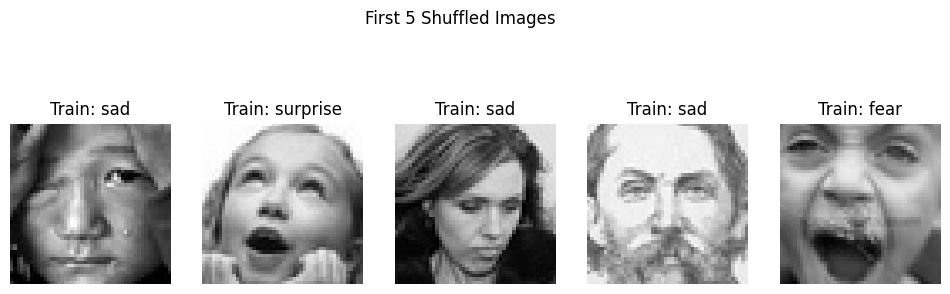

In [ ]:
# Show first 5 from train
plt.figure(figsize=(12, 4))
for i in range(5):
    img = cv2.imread(X_train_raw[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((48, 48))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Train: {y_train_raw[i]}")
    plt.axis('off')
plt.suptitle("First 5 Shuffled Images")
plt.show()

In [ ]:
def process_file(emotion, file_path):
    processed_image = preprocess_image(file_path)
    if processed_image is not None:
        return processed_image, label_map[emotion]
    return None

In [ ]:
X_train = []
y_train = []

In [ ]:
for emotion in emotion_labels:
    folder_path = os.path.join(train_data_path, emotion)
    files = os.listdir(folder_path)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_file, emotion, os.path.join(folder_path, f)): f for f in files}

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {emotion}", unit="img"):
            result = future.result()
            if result is not None:
                processed_image, label = result
                X_train.append(processed_image)
                y_train.append(label)

Processing surprise: 100%|██████████| 3171/3171 [00:20<00:00, 154.58img/s]


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_cat_train = to_categorical(y_train, num_classes=len(emotion_labels))

print(f'Loaded {len(X_train)} images successfully.')

Loaded 28709 images successfully.


In [ ]:
X_test = []
y_test = []

In [ ]:
for emotion in emotion_labels:
    folder_path = os.path.join(test_data_path, emotion)
    files = os.listdir(folder_path)

    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = {executor.submit(process_file, emotion, os.path.join(folder_path, f)): f for f in files}

        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing {emotion}", unit="img"):
            result = future.result()
            if result is not None:
                processed_image, label = result
                X_test.append(processed_image)
                y_test.append(label)

Processing surprise: 100%|██████████| 831/831 [00:04<00:00, 174.24img/s]


In [ ]:
X_test = np.array(X_test)
y_test = np.array(y_test)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_cat_test = to_categorical(y_test, num_classes=len(emotion_labels))

print(f'Loaded {len(X_test)} images successfully.')

Loaded 7178 images successfully.


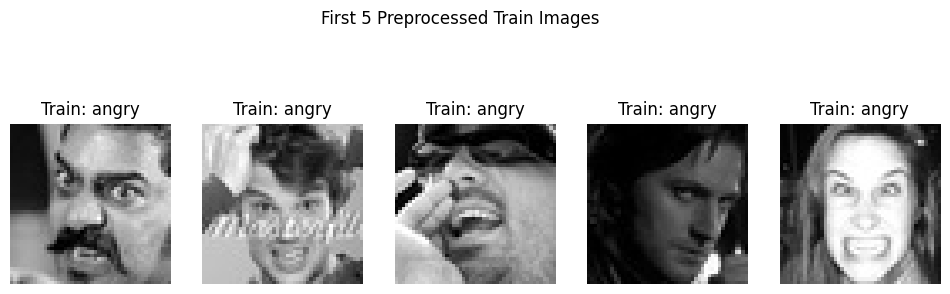

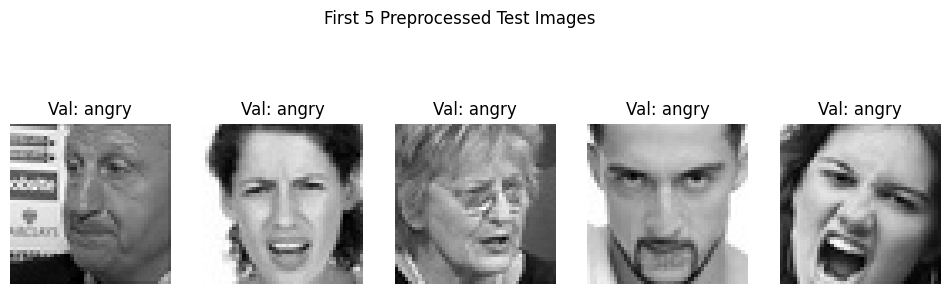

In [ ]:
# Show first 5 preprocessed train images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Train: {emotion_labels[y_train[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Train Images")
plt.show()

# Show first 5 preprocessed validation images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f"Val: {emotion_labels[y_test[i]]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Test Images")
plt.show()

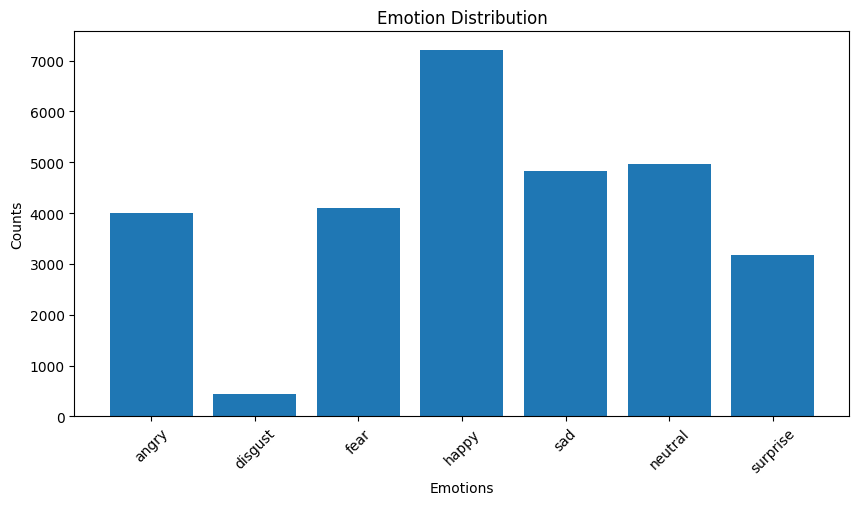

In [ ]:
value_counts = np.bincount(y_train)
plt.figure(figsize=(10, 5))
plt.bar(emotion_labels, value_counts)
plt.xlabel("Emotions")
plt.ylabel("Counts")
plt.title("Emotion Distribution")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# shuffle the data
shuffle_train_indices = np.random.permutation(len(X_train)-1)

X_train = X_train[shuffle_train_indices]
y_train = y_train[shuffle_train_indices]

shuffle_test_indices = np.random.permutation(len(X_test)-1)

X_test = X_test[shuffle_test_indices]
y_test = y_test[shuffle_test_indices]

print("Shuffled Data Successfully")

Shuffled Data Successfully


In [ ]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import prewitt, scharr, laplace, gabor
from skimage.restoration import denoise_tv_chambolle
import cv2
import numpy as np

def extract_features_from_image(img):
    # Ensure the image is in 2D grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Normalize image for OpenCV if needed
    if gray.max() <= 1:
        gray = (gray * 255).astype(np.uint8)

    # 1. Sobel Edge Detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge = np.sqrt(sobelx**2 + sobely**2)

    # 2. Canny Edge Detection
    try:
        canny_edges = cv2.Canny(gray, 100, 200)
    except Exception as e:
        print(f"Error applying Canny edge detection: {e}")
        canny_edges = np.zeros_like(gray)

    # 3. HOG
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # 4. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

    # 5. Gaussian Blur
    blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)

    # 6. Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # 7. Scharr
    scharr_edge = scharr(gray)

    # 8. Prewitt
    prewitt_edge = prewitt(gray)

    # 9. Median Filter
    median_filtered = cv2.medianBlur(gray, 5)

    # 10. Gabor Filter
    gabor_response, _ = gabor(gray, frequency=0.6)

    # Return all 2D feature images
    return (
        sobel_edge,
        canny_edges,
        hog_image,
        lbp,
        blurred_img,
        laplacian,
        scharr_edge,
        prewitt_edge,
        median_filtered,
        gabor_response
    )

# Dataset feature extraction (same as before)
def extract_features_for_dataset(X_data):
    all_features = []
    for img in X_data:
        img = img.reshape(48, 48)
        features = extract_features_from_image(img)
        all_features.append(features)
    return np.array(all_features)

In [ ]:
from joblib import Parallel, delayed

def extract_features_parallel(X_data, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(extract_features_from_image)(img.reshape(IMG_SIZE, IMG_SIZE)) for img in X_data
    )
    return np.array(results)

In [ ]:
# Assuming X_train and X_test are your training and test datasets
X_train_feat = extract_features_parallel(X_train)
X_test_feat = extract_features_parallel(X_test)

# Print shapes of the extracted feature sets
print(f"Shape of extracted features for X_train: {X_train_feat.shape}")
print(f"Shape of extracted features for X_test: {X_test_feat.shape}")

Shape of extracted features for X_train: (28708, 10, 48, 48)
Shape of extracted features for X_test: (7177, 10, 48, 48)


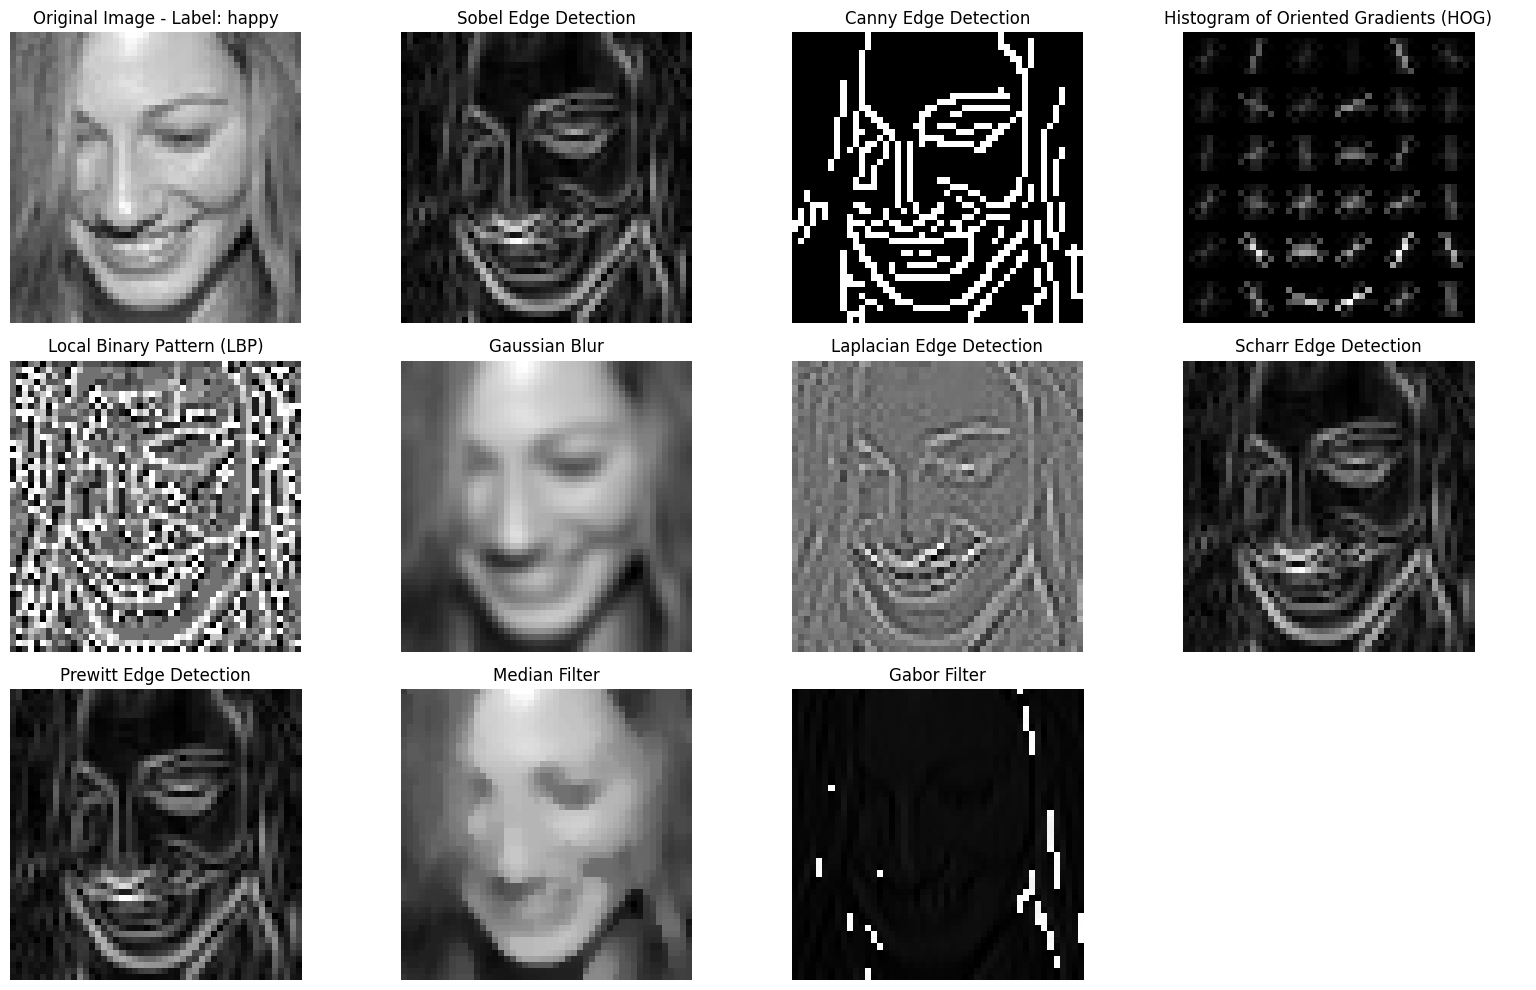

In [ ]:
# First image and label
first_image = X_train[0].reshape(48, 48)
first_image_label = emotion_labels[y_train[0]]

# Extract features (this function now returns 10 feature images)
features = extract_features_from_image(first_image)

# Titles for each feature
titles = [
    f"Original Image - Label: {first_image_label}",
    "Sobel Edge Detection",
    "Canny Edge Detection",
    "Histogram of Oriented Gradients (HOG)",
    "Local Binary Pattern (LBP)",
    "Gaussian Blur",
    "Laplacian Edge Detection",
    "Scharr Edge Detection",
    "Prewitt Edge Detection",
    "Median Filter",
    "Gabor Filter"
]

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Flatten axes to loop easily
axes = axes.flatten()

# Plot original image first
axes[0].imshow(first_image, cmap='gray')
axes[0].set_title(titles[0])
axes[0].axis('off')

# Plot all feature maps
for i, feature_img in enumerate(features):
    axes[i + 1].imshow(feature_img, cmap='gray')
    axes[i + 1].set_title(titles[i + 1])
    axes[i + 1].axis('off')

# Hide any remaining unused subplots (if less than 12)
for j in range(len(features) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Flatten the extracted feature set
X_train_feat_flattened = X_train_feat.reshape(X_train_feat.shape[0], -1)  # Flatten each sample
X_test_feat_flattened = X_test_feat.reshape(X_test_feat.shape[0], -1)  # Flatten each sample

# Print the new shape to verify
print(f"Shape of flattened features for X_train: {X_train_feat_flattened.shape}")
print(f"Shape of flattened features for X_test: {X_test_feat_flattened.shape}")

Shape of flattened features for X_train: (28708, 23040)
Shape of flattened features for X_test: (7177, 23040)


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

In [ ]:
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights_array))
class_weights

{0: np.float64(1.0265689254425174),
 1: np.float64(9.406290956749672),
 2: np.float64(1.0010111928588863),
 3: np.float64(0.5684189684189684),
 4: np.float64(0.8490979000295771),
 5: np.float64(0.826010645950223),
 6: np.float64(1.2937359170797658)}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, BatchNormalization, SpatialDropout2D, Activation
)
from tensorflow.keras.regularizers import l2


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(512, (3,3), activation='relu', padding='same',),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.4),

    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,17

 Total params: 2,104,455 (8.03 MB)

 Trainable params: 2,102,471 (8.02 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=5,
    verbose=1,
    mode='max',
    min_lr=1e-6
)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_train.shape

(22966, 48, 48, 1)

In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.1697 - loss: 2.1445 - val_accuracy: 0.0235 - val_loss: 3.4073 - learning_rate: 0.0010
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.2702 - loss: 1.8073 - val_accuracy: 0.3417 - val_loss: 1.7087 - learning_rate: 0.0010
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.3343 - loss: 1.7100 - val_accuracy: 0.3727 - val_loss: 1.6192 - learning_rate: 0.0010
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.3641 - loss: 1.6381 - val_accuracy: 0.3936 - val_loss: 1.5910 - learning_rate: 0.0010
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 382s 1s/step - accuracy: 0.3704 - loss: 1.6074 - val_accuracy: 0.3586 - val_loss: 1.6828 - learning_rate: 0.0010
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.3919 - loss: 1.5597 - val_accuracy: 0.2847 - val_loss: 1.9089 - learning_rate: 0.0010
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 441s 1s/step - accuracy: 0.3945 - loss: 1.

In [ ]:
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test.shape

(2484, 48, 48, 1)

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.5673 - loss: 1.1557
Test Accuracy: 56.58%


In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

225/225 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.35      0.42       958
           1       0.24      0.68      0.35       111
           2       0.50      0.16      0.24      1024
           3       0.85      0.78      0.81      1774
           4       0.42      0.55      0.48      1247
           5       0.48      0.61      0.54      1233
           6       0.63      0.80      0.71       830

    accuracy                           0.57      7177
   macro avg       0.52      0.56      0.51      7177
weighted avg       0.58      0.57      0.55      7177



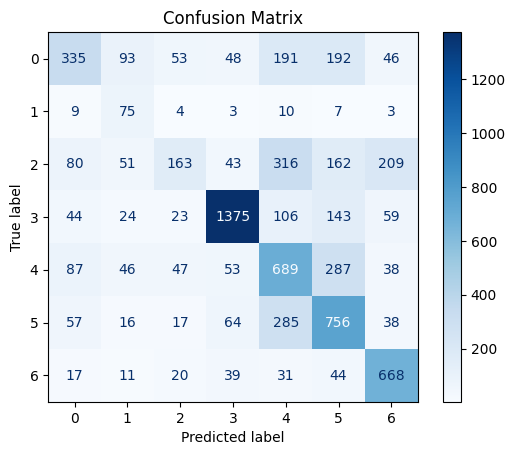

In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

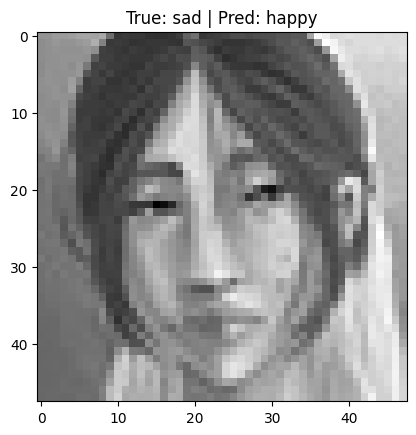

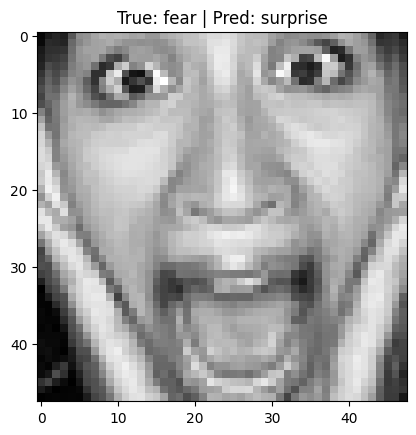

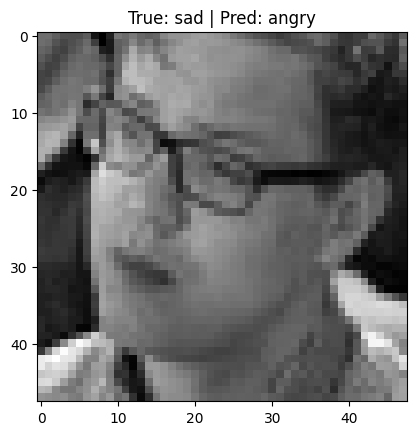

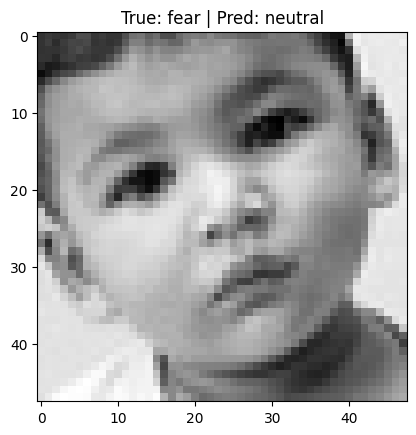

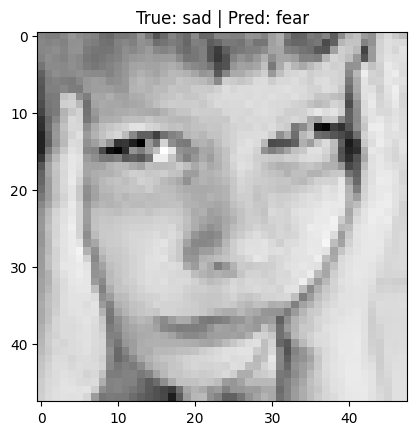

In [ ]:
# Visualize some missclassified samples
wrong = np.where(y_pred != y_test)[0]


for i in wrong[:5]:
    plt.imshow(X_test[i], cmap='gray')
    plt.title(f"True: {emotion_labels[y_test[i]]} | Pred: {emotion_labels[y_pred[i]]}")
    plt.show()

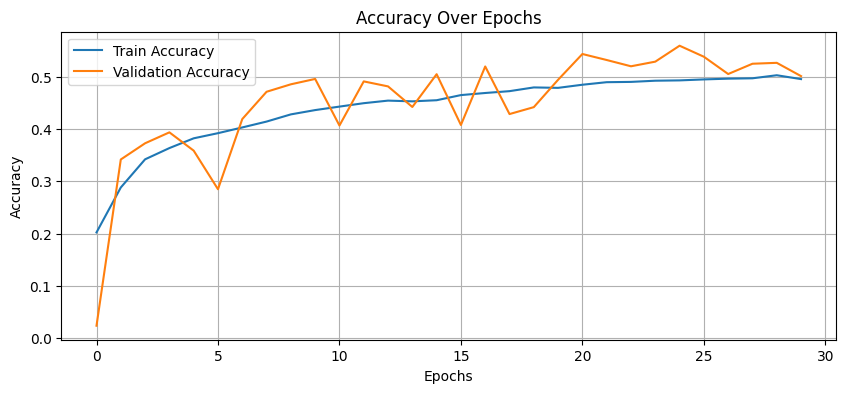

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

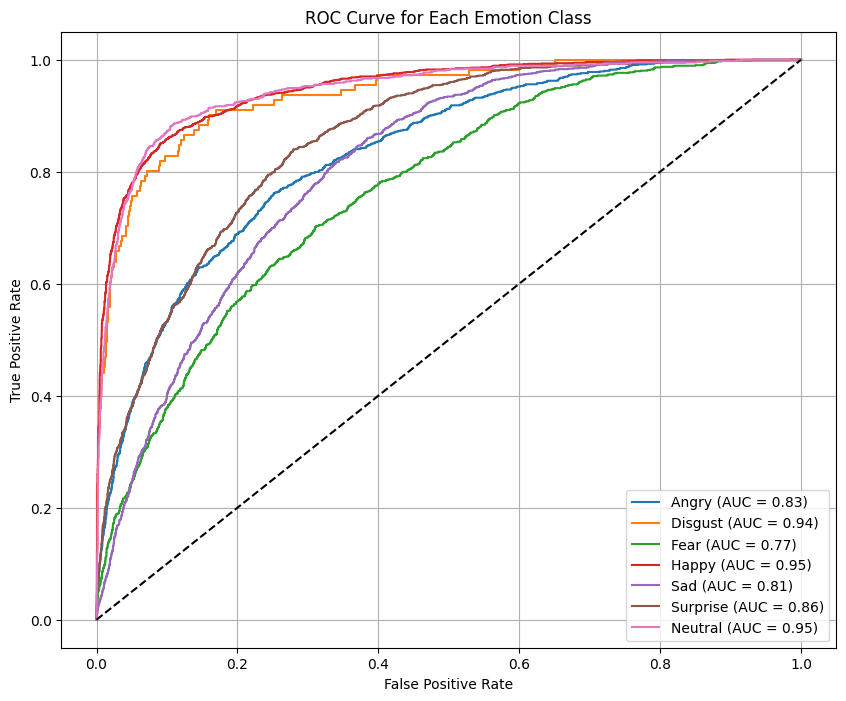

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Your integer class labels (0 to 6), shape: (num_samples,)
# Example:
# y_true = np.array([0, 2, 1, 4, ...])
# y_pred_probs = model.predict(X_test)  # shape: (num_samples, 7)

# 1. Binarize the y_true just for ROC plotting
y_true_bin = label_binarize(y_test, classes=list(range(7)))  # shape: (num_samples, 7)

# 2. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 3. Plot ROC curves
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Emotion Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Loaded 28709 train and 7178 test images.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✅ Test Accuracy: 44.00%

Classification Report:
              precision    recall  f1-score   support

       angry       0.32      0.27      0.29       958
     disgust       0.42      0.20      0.27       111
        fear       0.30      0.22      0.25      1024
       happy       0.56      0.74      0.64      1774
         sad       0.33      0.29      0.31      1247
     neutral       0.40      0.43      0.41      1233
    surprise       0.55      0.54      0.54       831

    accuracy                           0.44      7178
   macro avg       0.41      0.38      0.39      7178
weighted avg       0.42      0.44      0.42      7178



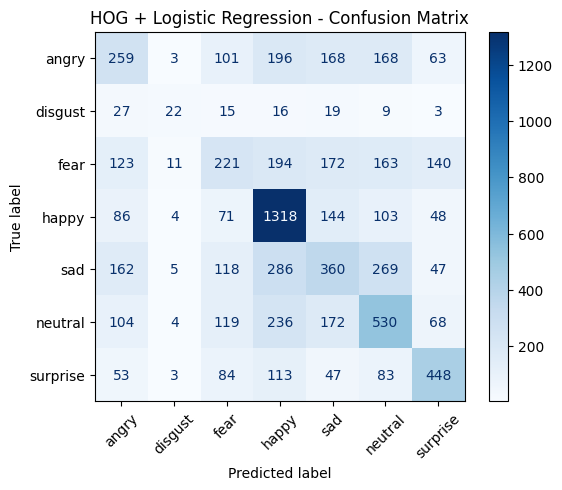

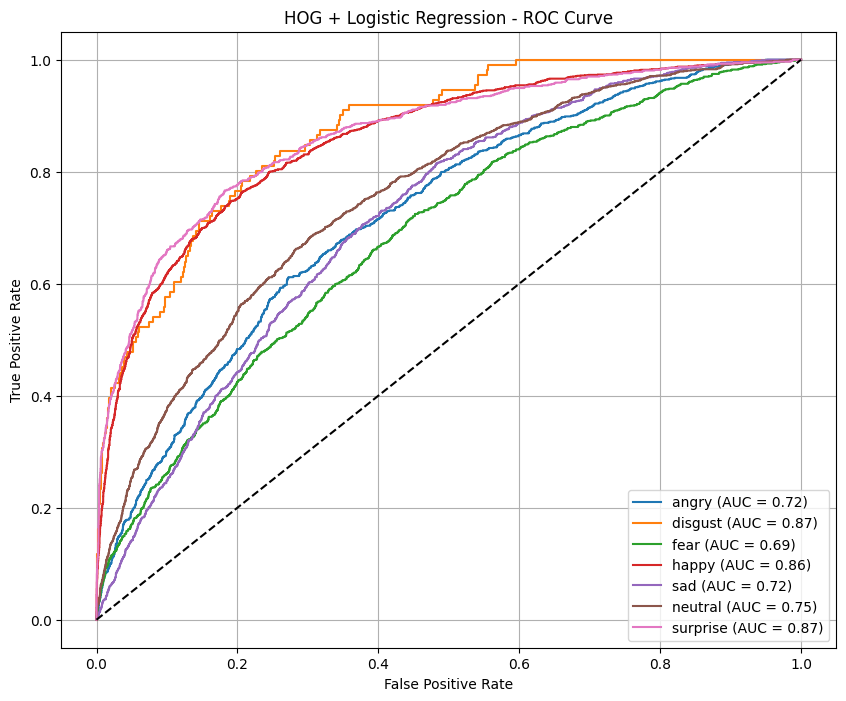

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Paths
train_data_path = '/content/archive/train/'
test_data_path = '/content/archive/test/'
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprise']
label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

# Load & preprocess grayscale images
def load_images(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        if label in emotion_labels:
            for file in os.listdir(os.path.join(data_dir, label)):
                if file.endswith('.jpg'):
                    path = os.path.join(data_dir, label, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (48, 48))
                    img = img.astype('float32') / 255.0
                    images.append(img)
                    labels.append(label_map[label])
    return np.array(images), np.array(labels)

# HOG extractor
def extract_hog_features(X):
    features = []
    for img in X:
        fd = hog(img, orientations=9, pixels_per_cell=(8, 8),
                 cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
        features.append(fd)
    return np.array(features)

# Load data
X_train_raw, y_train = load_images(train_data_path)
X_test_raw, y_test = load_images(test_data_path)
print(f"Loaded {len(X_train_raw)} train and {len(X_test_raw)} test images.")

# Extract HOG
X_train_hog = extract_hog_features(X_train_raw)
X_test_hog = extract_hog_features(X_test_raw)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train_hog, y_train)

# Predict
y_pred = model.predict(X_test_hog)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("HOG + Logistic Regression - Confusion Matrix")
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=list(range(7)))
y_pred_probs = model.predict_proba(X_test_hog)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('HOG + Logistic Regression - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Loaded 28709 train and 7178 test images.

✅ Test Accuracy: 31.07%

Classification Report:
              precision    recall  f1-score   support

       angry       0.29      0.16      0.21       958
     disgust       1.00      0.27      0.43       111
        fear       0.29      0.15      0.20      1024
       happy       0.30      0.59      0.40      1774
         sad       0.25      0.20      0.22      1247
     neutral       0.26      0.23      0.25      1233
    surprise       0.55      0.38      0.45       831

    accuracy                           0.31      7178
   macro avg       0.42      0.28      0.31      7178
weighted avg       0.32      0.31      0.29      7178



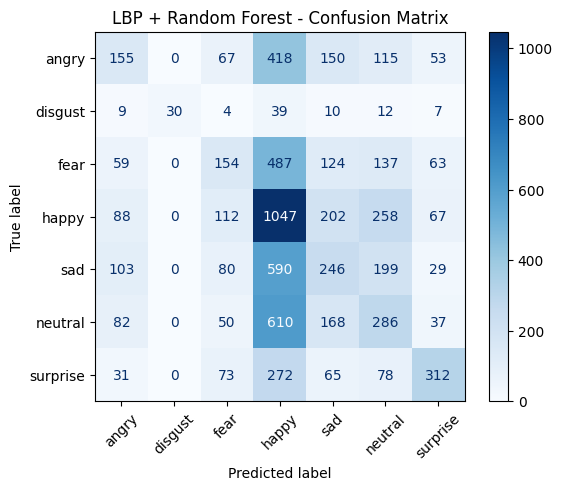

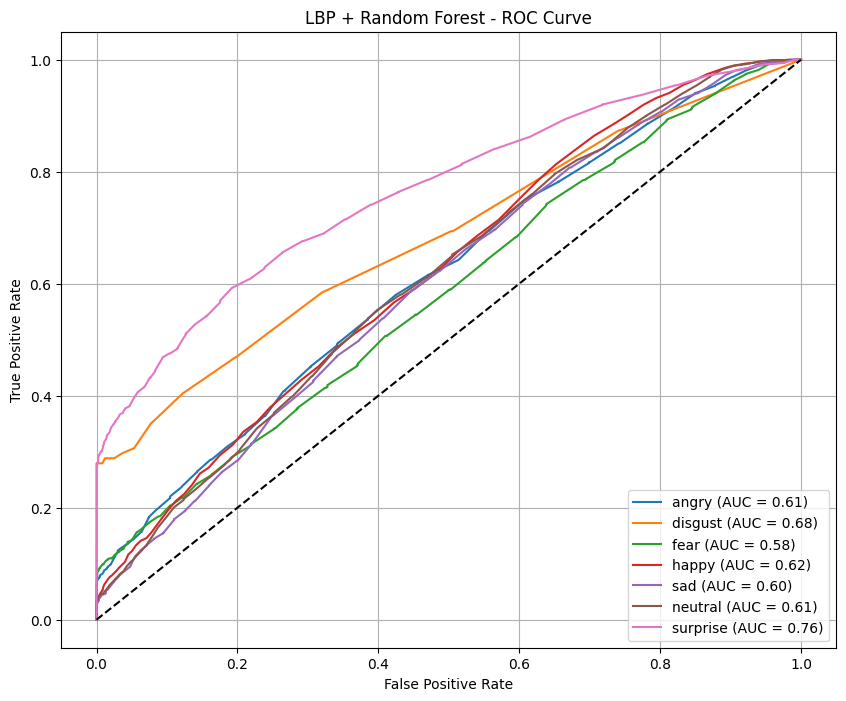

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Paths
train_data_path = '/content/archive/train/'
test_data_path = '/content/archive/test/'
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprise']
label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

# Load & preprocess grayscale images
def load_images(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        if label in emotion_labels:
            for file in os.listdir(os.path.join(data_dir, label)):
                if file.endswith('.jpg'):
                    path = os.path.join(data_dir, label, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (48, 48))
                    img = img.astype('float32') / 255.0
                    images.append(img)
                    labels.append(label_map[label])
    return np.array(images), np.array(labels)

# LBP extractor
def extract_lbp_features(X):
    features = []
    for img in X:
        lbp = local_binary_pattern((img * 255).astype(np.uint8), P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

# Load data
X_train_raw, y_train = load_images(train_data_path)
X_test_raw, y_test = load_images(test_data_path)
print(f"Loaded {len(X_train_raw)} train and {len(X_test_raw)} test images.")

# Extract LBP
X_train_lbp = extract_lbp_features(X_train_raw)
X_test_lbp = extract_lbp_features(X_test_raw)

# Train Random Forest
model = RandomForestClassifier(n_estimators=150, random_state=42)
model.fit(X_train_lbp, y_train)

# Predict
y_pred = model.predict(X_test_lbp)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("LBP + Random Forest - Confusion Matrix")
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=list(range(7)))
y_pred_probs = model.predict_proba(X_test_lbp)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LBP + Random Forest - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


✅ Loaded 28709 train and 7178 test images.

✅ SVM Test Accuracy: 24.71%

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
         sad       0.00      0.00      0.00      1247
     neutral       0.00      0.00      0.00      1233
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


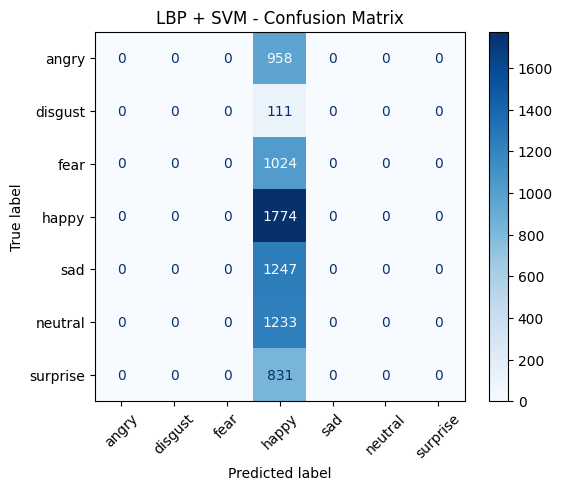

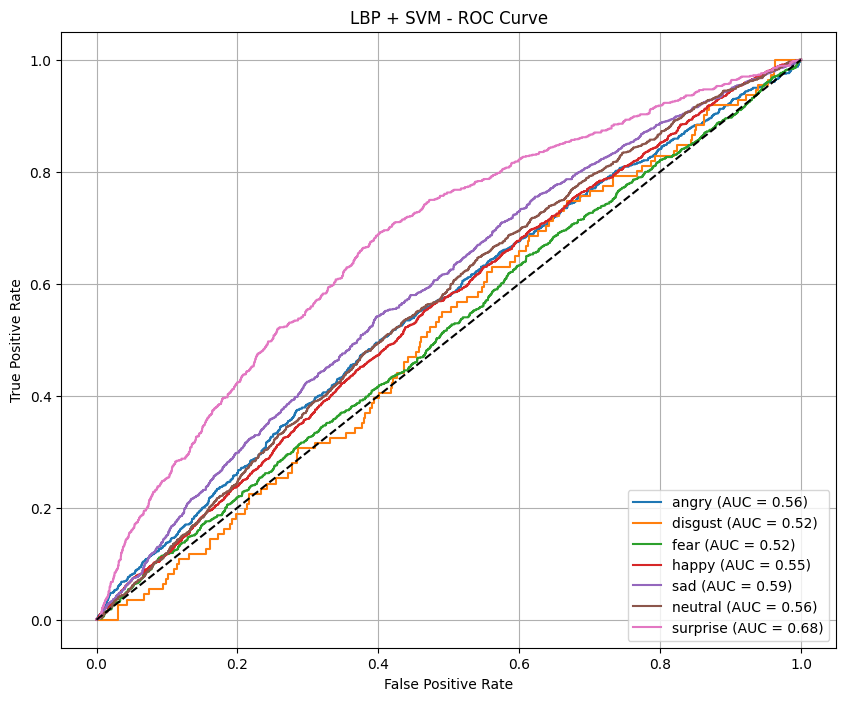

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler

# Paths
train_data_path = '/content/archive/train/'
test_data_path = '/content/archive/test/'
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'neutral', 'surprise']
label_map = {emotion: idx for idx, emotion in enumerate(emotion_labels)}

# Load & preprocess grayscale images
def load_images(data_dir):
    images, labels = [], []
    for label in os.listdir(data_dir):
        if label in emotion_labels:
            for file in os.listdir(os.path.join(data_dir, label)):
                if file.endswith('.jpg'):
                    path = os.path.join(data_dir, label, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (48, 48))
                    img = img.astype('float32') / 255.0
                    images.append(img)
                    labels.append(label_map[label])
    return np.array(images), np.array(labels)

# LBP extractor
def extract_lbp_features(X):
    features = []
    for img in X:
        lbp = local_binary_pattern((img * 255).astype(np.uint8), P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

# Load and process data
X_train_raw, y_train = load_images(train_data_path)
X_test_raw, y_test = load_images(test_data_path)
print(f"✅ Loaded {len(X_train_raw)} train and {len(X_test_raw)} test images.")

X_train_lbp = extract_lbp_features(X_train_raw)
X_test_lbp = extract_lbp_features(X_test_raw)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lbp)
X_test_scaled = scaler.transform(X_test_lbp)

# Train SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate
y_pred = svm_model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ SVM Test Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=emotion_labels))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("LBP + SVM - Confusion Matrix")
plt.show()

# ROC Curve
y_test_bin = label_binarize(y_test, classes=list(range(7)))
y_pred_probs = svm_model.predict_proba(X_test_scaled)

fpr, tpr, roc_auc = {}, {}, {}
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(7):
    plt.plot(fpr[i], tpr[i], label=f'{emotion_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LBP + SVM - ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
